# Comparing a USGSCSM and ISIS camera for MRO CTX

In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Download Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2019-10-18 16:27:17--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/K11_057871_1602_XN_19S163W.IMG’ not modified on server. Omitting download.



## Ingest the image into ISIS and attach ALE spice via spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

## Create an ISD and store it next to the cube

In [4]:
usgscsm_str = ale.loads(cub_loc, formatter='usgscsm')
csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

Trying <class 'ale.drivers.mess_drivers.MessengerMdisIsisLabelIsisSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.isis_ideal_drivers.IdealLsIsisLabelIsisSpiceDriver'>
Failed: 'SampleDetectors'

Trying <class 'ale.drivers.mro_drivers.MroCtxIsisLabelIsisSpiceDriver'>


Traceback (most recent call last):
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/drivers/__init__.py", line 68, in load
    res.instrument_id
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/drivers/mess_drivers.py", line 72, in instrument_id
    return ID_LOOKUP[super().instrument_id]
KeyError: 'CTX'
Traceback (most recent call last):
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/drivers/__init__.py", line 71, in load
    return formatter(driver)
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/formatters/usgscsm_formatter.py", line 61, in to_usgscsm
    'sample' : driver.detector_center_sample
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/drivers/isis_ideal_drivers.py", line 185, in detector_center_sample
    return self.label['IsisCube']['Instrument']['SampleDetectors'] / 2.0
  File "/scratch/conda/envs/knoten/lib/python3.7/site-packages/pvl/_collections.py", line 123, in __getitem__
 

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

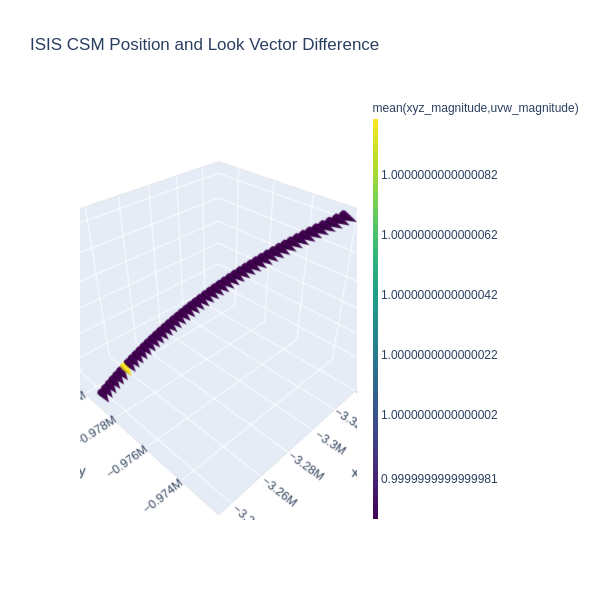

In [6]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

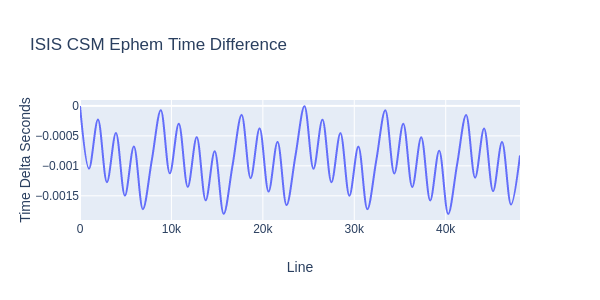

In [7]:
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_ephem_plot_bytes)

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.797429,0.458993,-3.063732,-3.703996e-06,1.810833e-07,9.747349e-06
std,26.400641,158.965444,53.142868,2.233993e-06,2.228932e-07,5.880897e-06
min,-71.729890,-424.307863,-155.220184,-7.771895e-06,-2.506084e-07,-6.050715e-15
25%,-15.891671,-95.349686,-35.627496,-5.734120e-06,8.758929e-10,4.797673e-06
50%,2.051780,-6.099958,-0.000025,-3.619549e-06,1.418602e-07,9.821174e-06
75%,17.774129,96.110511,29.574612,-1.759782e-06,3.232953e-07,1.486458e-05
max,69.202685,449.059688,138.856601,1.554312e-15,6.874317e-07,1.963288e-05


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

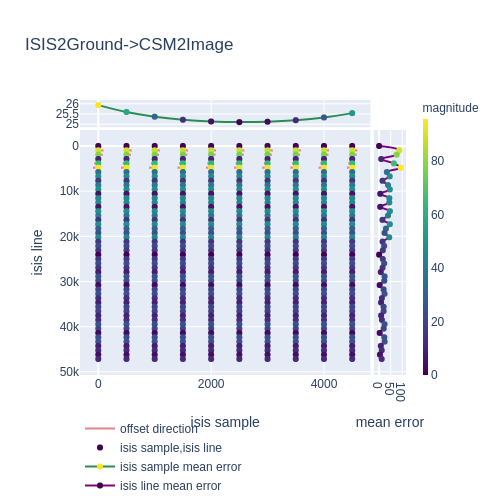

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.080074,-0.115607
std,6.250016,32.539016
min,-17.815858,-93.941850
25%,-3.666350,-19.489026
50%,0.209526,1.216842
75%,3.504867,19.439611
max,16.711524,88.477623


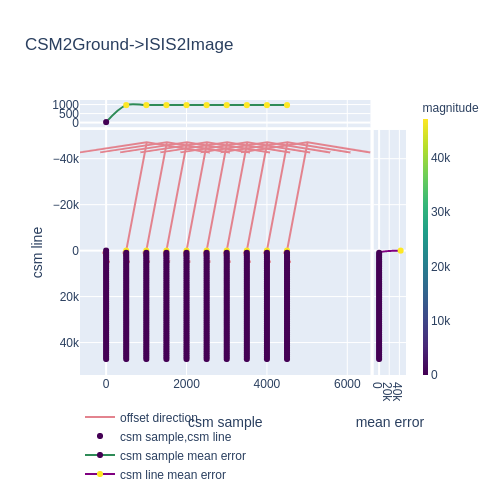

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-848.866469,9.315378
std,6276.714650,75.370325
min,-47163.363143,-88.777886
25%,-4.063025,-19.515970
50%,-0.338736,-1.217221
75%,3.762168,21.332926
max,17.879550,511.173036


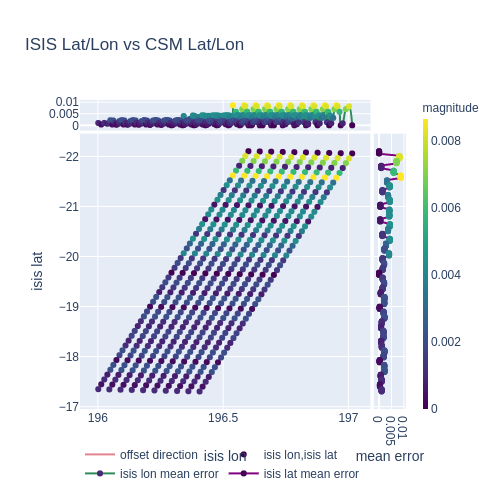

In [14]:
Image(isiscsm_plotlatlon.to_image())

In [15]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,500.000000,500.000000
mean,-0.000009,-0.000009
std,0.002891,0.000963
min,-0.008201,-0.002749
25%,-0.001725,-0.000580
50%,0.000109,0.000030
75%,0.001717,0.000562
max,0.007760,0.002592


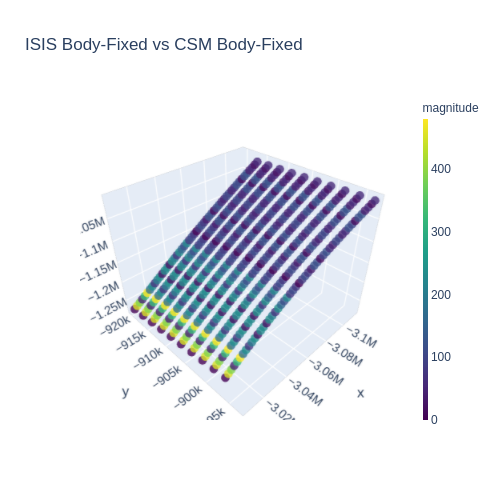

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,1.101302,-0.552344,0.490491
std,1.620946,159.046954,53.142291
min,-2.141189,-449.986599,-142.161606
25%,-0.319614,-96.321131,-31.475284
50%,-0.286815,6.010239,-1.691887
75%,2.816027,95.376885,32.652768
max,2.821763,424.857081,151.177938
